# Create Needle In A Haystack Visualization

Let's run through how to create the visualization for the Needle In A Hackstack Test.

At a highlevel, it's a two step process
1. Generate a pivot table based on the results
2. Use that pivot table as the basis for Google Slides (or whatever design tool ou want) custom formatting.

See the final [visualization](https://docs.google.com/presentation/d/15JEdEBjm32qBbqeYM6DK6G-3mUJd7FAJu-qEzj8IYLQ/edit?usp=sharing).
See the [overview video](https://twitter.com/GregKamradt/status/1729573848893579488) for this code.

Let's get started. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import json
import os
import glob

The assumption is that your individual test results will be saved to separate files. This is done to make concurrent requests easier.

If that isn't the case, feel free to change up the loading process below. The end result we want is a table with three columns (one row per test)
1. Context Length
2. Document Depth
3. Score Result

Change the folder location for where your results are stored. I'll use the original results folder for this test

## Load Data

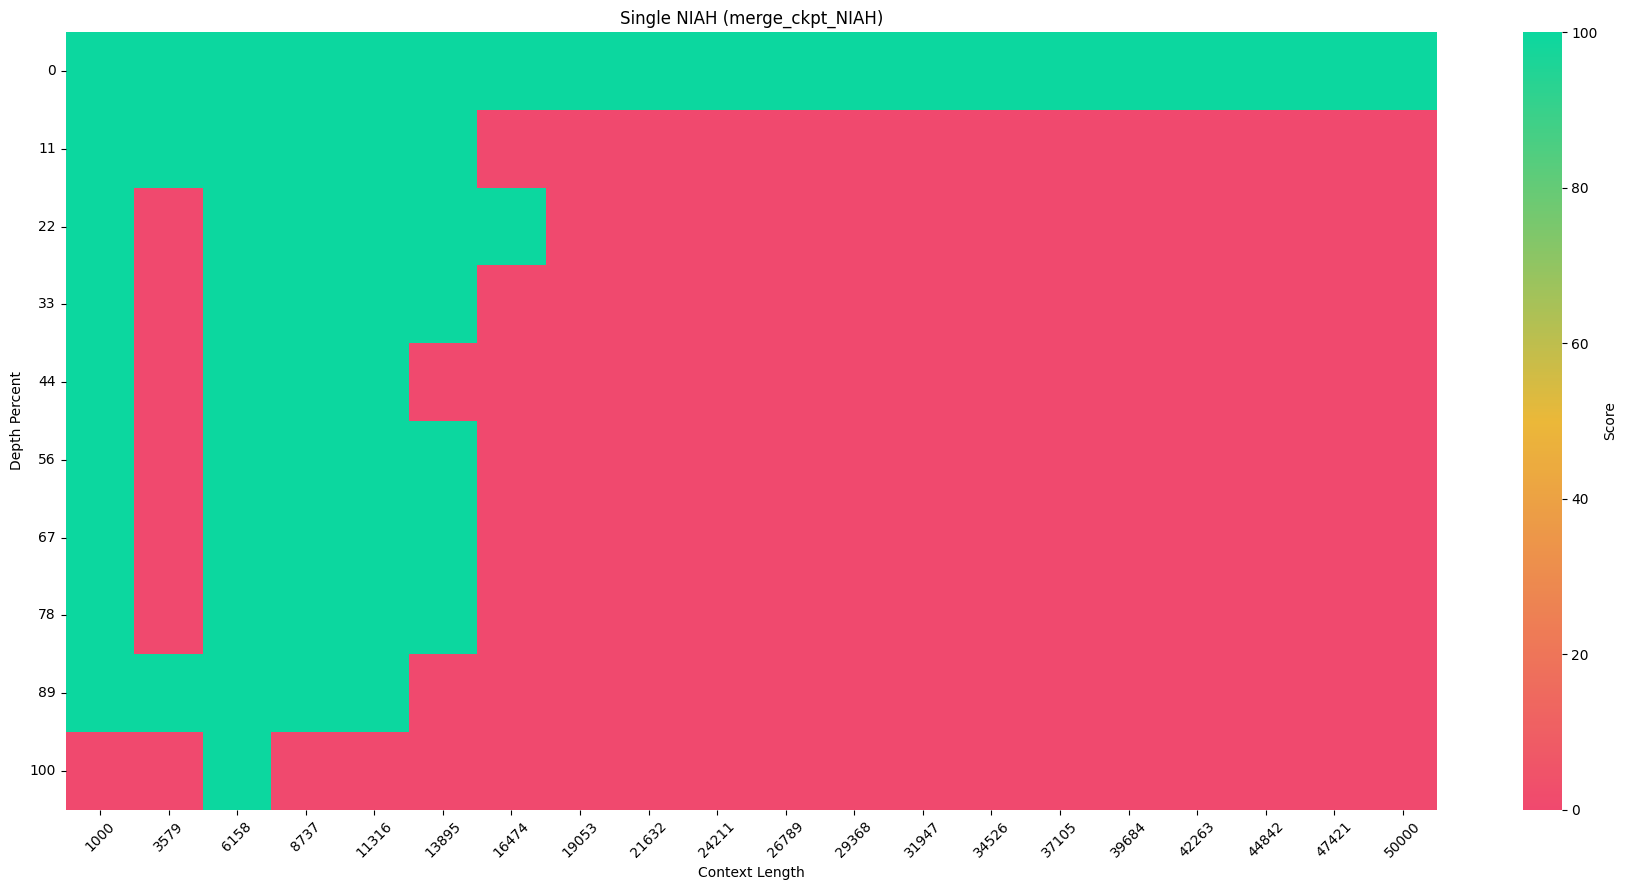

In [2]:
# Path to the directory containing JSON results
# model_name = 'llama-2-7b-80k_multi_qa'
# model_name = 'FILM-7B'
# model_name = 'llama-2-7b-80k'
# model_name = 'FILM-7B_musican_girl'
# model_name = 'Llama-2-7b-chat_musican_girl'
# model_name = 'Llama-3-8B-Instruct-80K-QLoRA-Merged_multi_qa'
model_name = 'merge_ckpt_NIAH'
folder_paths = [f'/data/zecheng/Retrieval_Head/results/graph/{model_name}_case{i}' for i in range(0, 1)] 

for folder_path in folder_paths:
    json_files = glob.glob(f"{folder_path}/*.json")
    data = dict()
    for file in json_files:
        with open(file, 'r') as f:
            json_data = json.load(f)
            document_depth = int(json_data.get("depth_percent", None))
            context_length = int(json_data.get("context_length", None))
            score = json_data.get("score", None)
            penalized_recall_score = json_data.get("penalized_recall_score", None)
            key = f'{document_depth}-{context_length}'
            key2 = f'{document_depth}-{context_length}-pen'
            if key not in data: data[key] = score
            else: data[key] += score

# average the scores
for key in data.keys(): 
    data[key] = data[key] / len(folder_paths)

# Creating a DataFrame
statics_data = []
for key in data:
    document_depth, context_length = int(key.split('-')[0]), int(key.split('-')[1])
    score = data[key]
    statics_data.append({"Document Depth": document_depth, "Context Length": context_length, "Score": score})

 
df = pd.DataFrame(statics_data)
pivot_table = pd.pivot_table(df, values='Score', index=['Document Depth', 'Context Length'], aggfunc='mean').reset_index() # This will aggregate
pivot_table = pivot_table.pivot(index="Document Depth", columns="Context Length", values="Score") # This will turn into a proper pivot

cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 9))

sns.heatmap(pivot_table, fmt="g", cmap=cmap, cbar_kws={'label': 'Score'}, vmin=0, vmax=100, ax=ax)
ax.set_title(f'Single NIAH ({model_name})')

plt.ylabel('Depth Percent')  # Y-axis label
plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
plt.tight_layout()  # Fits everything neatly into the figure area
plt.show()

Then let's create a pivot table. If you just ran the test once, then this step isn't needed (but it can be done anyway). If you ran the rest multiple times then this will average out your scores.

In [4]:
json_data

{'model': '/data/zecheng/hf_models/Llama-3-8B-Instruct-80K-QLoRA-Merged',
 'context_length': 34526,
 'depth_percent': '40_80',
 'version': 1,
 'needle': ['To maintain a healthy lifestyle, one should exercise regularly and eat vegetables.',
  "To boost your immune system, it's important to eat vegetables and get enough sleep."],
 'question': 'What is important for both maintaining a healthy lifestyle and boosting your immune system?',
 'model_response': 'Answer: To maintain a healthy lifestyle and boost your immune system, it is important to exercise regularly and eat vegetables. Exercise regularly by engaging in physical activities such as running,',
 'score': 100.0,
 'test_duration_seconds': 15.624256610870361,
 'test_timestamp_utc': '2024-06-15 16:32:11+0000',
 'penalized_recall_score': 66.66666666666666}

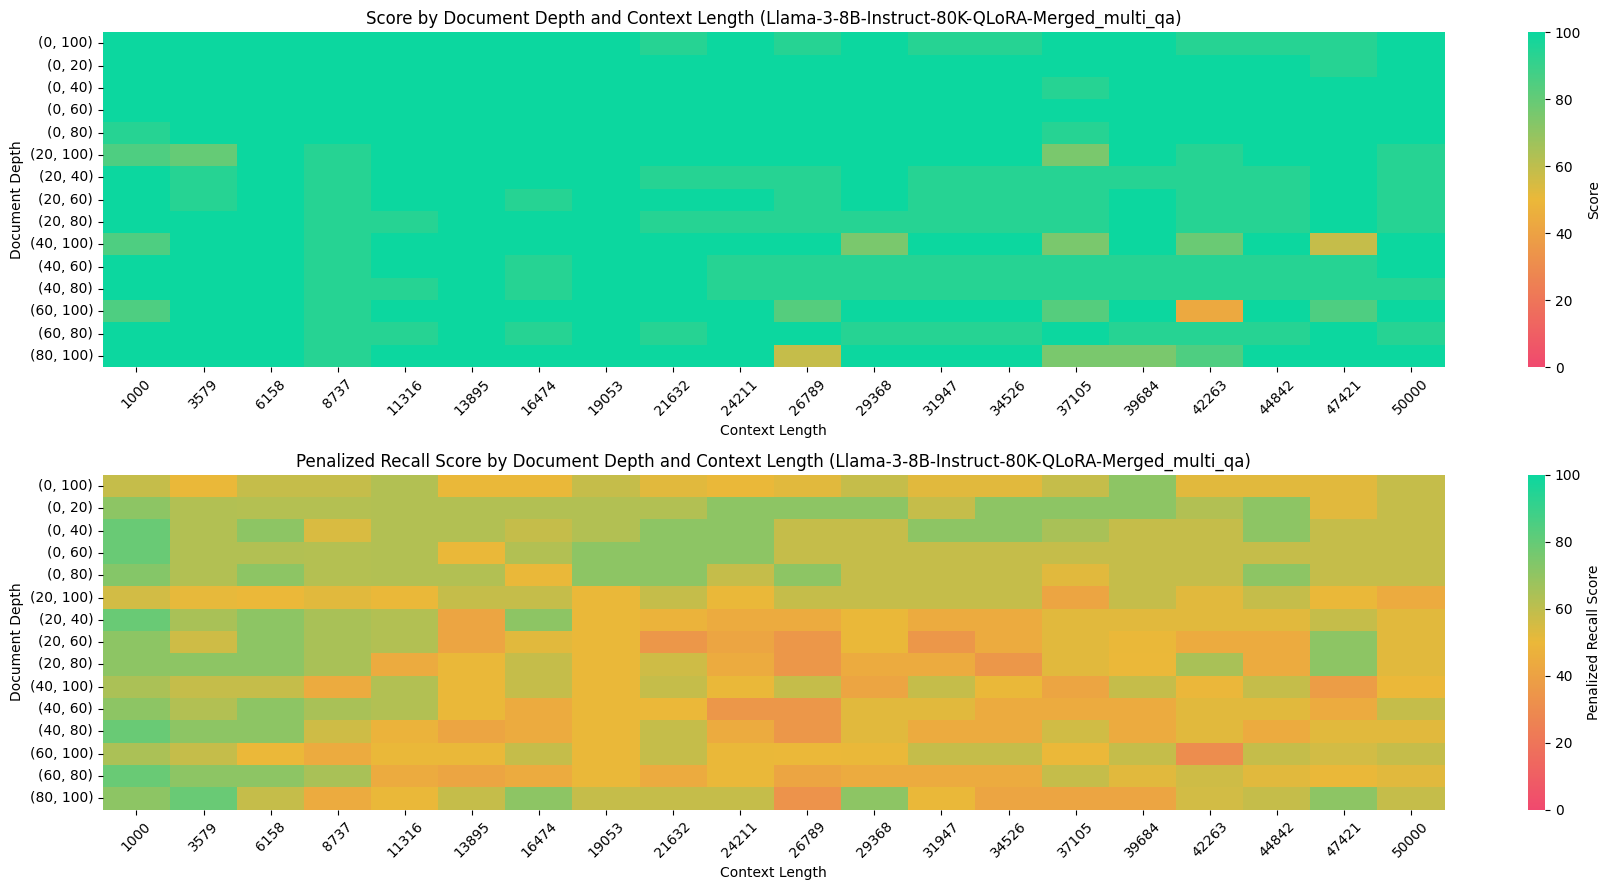

In [15]:
# Path to the directory containing JSON results
# model_name = 'llama-2-7b-80k_multi_qa'
# model_name = 'FILM-7B'
# model_name = 'llama-2-7b-80k'
# model_name = 'FILM-7B_musican_girl'
# model_name = 'Llama-2-7b-chat_musican_girl'
model_name = 'Llama-3-8B-Instruct-80K-QLoRA-Merged_multi_qa'
folder_paths = [f'/data/zecheng/Retrieval_Head/results/graph/{model_name}_case{i}' for i in range(4)] 
data1, data2 = dict(), dict()

for folder_path in folder_paths:
    json_files = glob.glob(f"{folder_path}/*.json")
    for file in json_files:
        with open(file, 'r') as f:
            json_data = json.load(f)
            document_depth = json_data.get("depth_percent", None)
            context_length = int(json_data.get("context_length", None))
            score = json_data.get("score", None)
            penalized_recall_score = json_data.get("penalized_recall_score", None)
            key = f'{document_depth}-{context_length}'
            key2 = f'{document_depth}-{context_length}-pen'
            if key not in data1: data1[key] = score
            else: data1[key] += score
            if key2 not in data2: data2[key2] = penalized_recall_score
            else: data2[key2] += penalized_recall_score

# average the scores
for key in data1.keys(): data1[key] = data1[key] / len(folder_paths)
for key in data2.keys(): data2[key] = data2[key] / len(folder_paths)

# Creating a DataFrame
statics_data1 = []
for key in data1:
    document_depth, context_length = key.split('-')[0].split("_"), int(key.split('-')[1])
    document_depth = f"({document_depth[0]}, {document_depth[1]})"
    score = data1[key]
    statics_data1.append({"Document Depth": document_depth, "Context Length": context_length, "Score": score})
statics_data2 = []
for key in data2:
    document_depth, context_length = key.split('-')[0].split("_"), int(key.split('-')[1])
    document_depth = f"({document_depth[0]}, {document_depth[1]})"
    score = data2[key]
    statics_data2.append({"Document Depth": document_depth, "Context Length": context_length, "Score": score})

# 前面的代码已经生成了 statics_data1 和 statics_data2
df1 = pd.DataFrame(statics_data1)
pivot_table1 = pd.pivot_table(df1, values='Score', index=['Document Depth'], columns=['Context Length'], aggfunc='mean')

df2 = pd.DataFrame(statics_data2)
pivot_table2 = pd.pivot_table(df2, values='Score', index=['Document Depth'], columns=['Context Length'], aggfunc='mean')

# 创建自定义色彩映射
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])

# 创建图形和子图
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 9))  # 1行2列的子图

# 第一个子图
sns.heatmap(pivot_table1, fmt="g", cmap=cmap, cbar_kws={'label': 'Score'}, vmin=0, vmax=100, ax=ax[0])
ax[0].set_title(f'Score by Document Depth and Context Length ({model_name})')
# ax[0].set_xlabel('Context Length')
# ax[0].set_ylabel('Document Depth')
ax[0].tick_params(axis='x', rotation=45)
ax[0].tick_params(axis='y', rotation=0)

# 第二个子图
sns.heatmap(pivot_table2, fmt="g", cmap=cmap, cbar_kws={'label': 'Penalized Recall Score'}, vmin=0, vmax=100, ax=ax[1])
ax[1].set_title(f'Penalized Recall Score by Document Depth and Context Length ({model_name})')
ax[1].set_xlabel('Context Length')
ax[1].set_ylabel('Document Depth')
ax[1].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='y', rotation=0)

plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()

# 同时绘制多张图，做对比

   Document Depth  Context Length  Score
0            56.0            1000  100.0
1            11.0            1000  100.0
2            44.0            1000  100.0
3            33.0            1000  100.0
4            22.0            1000  100.0
You have 130 rows
   Document Depth  Context Length  Score
0            56.0            1000  100.0
1            11.0            1000  100.0
2            44.0            1000  100.0
3            33.0            1000  100.0
4            22.0            1000  100.0
You have 130 rows
   Document Depth  Context Length  Score
0            56.0            1000  100.0
1            11.0            1000  100.0
2            44.0            1000  100.0
3            33.0            1000  100.0
4            22.0            1000  100.0
You have 130 rows
   Document Depth  Context Length  Score
0            56.0            1000   90.0
1            11.0            1000   90.0
2            44.0            1000   90.0
3            33.0            1000   90.0
4  

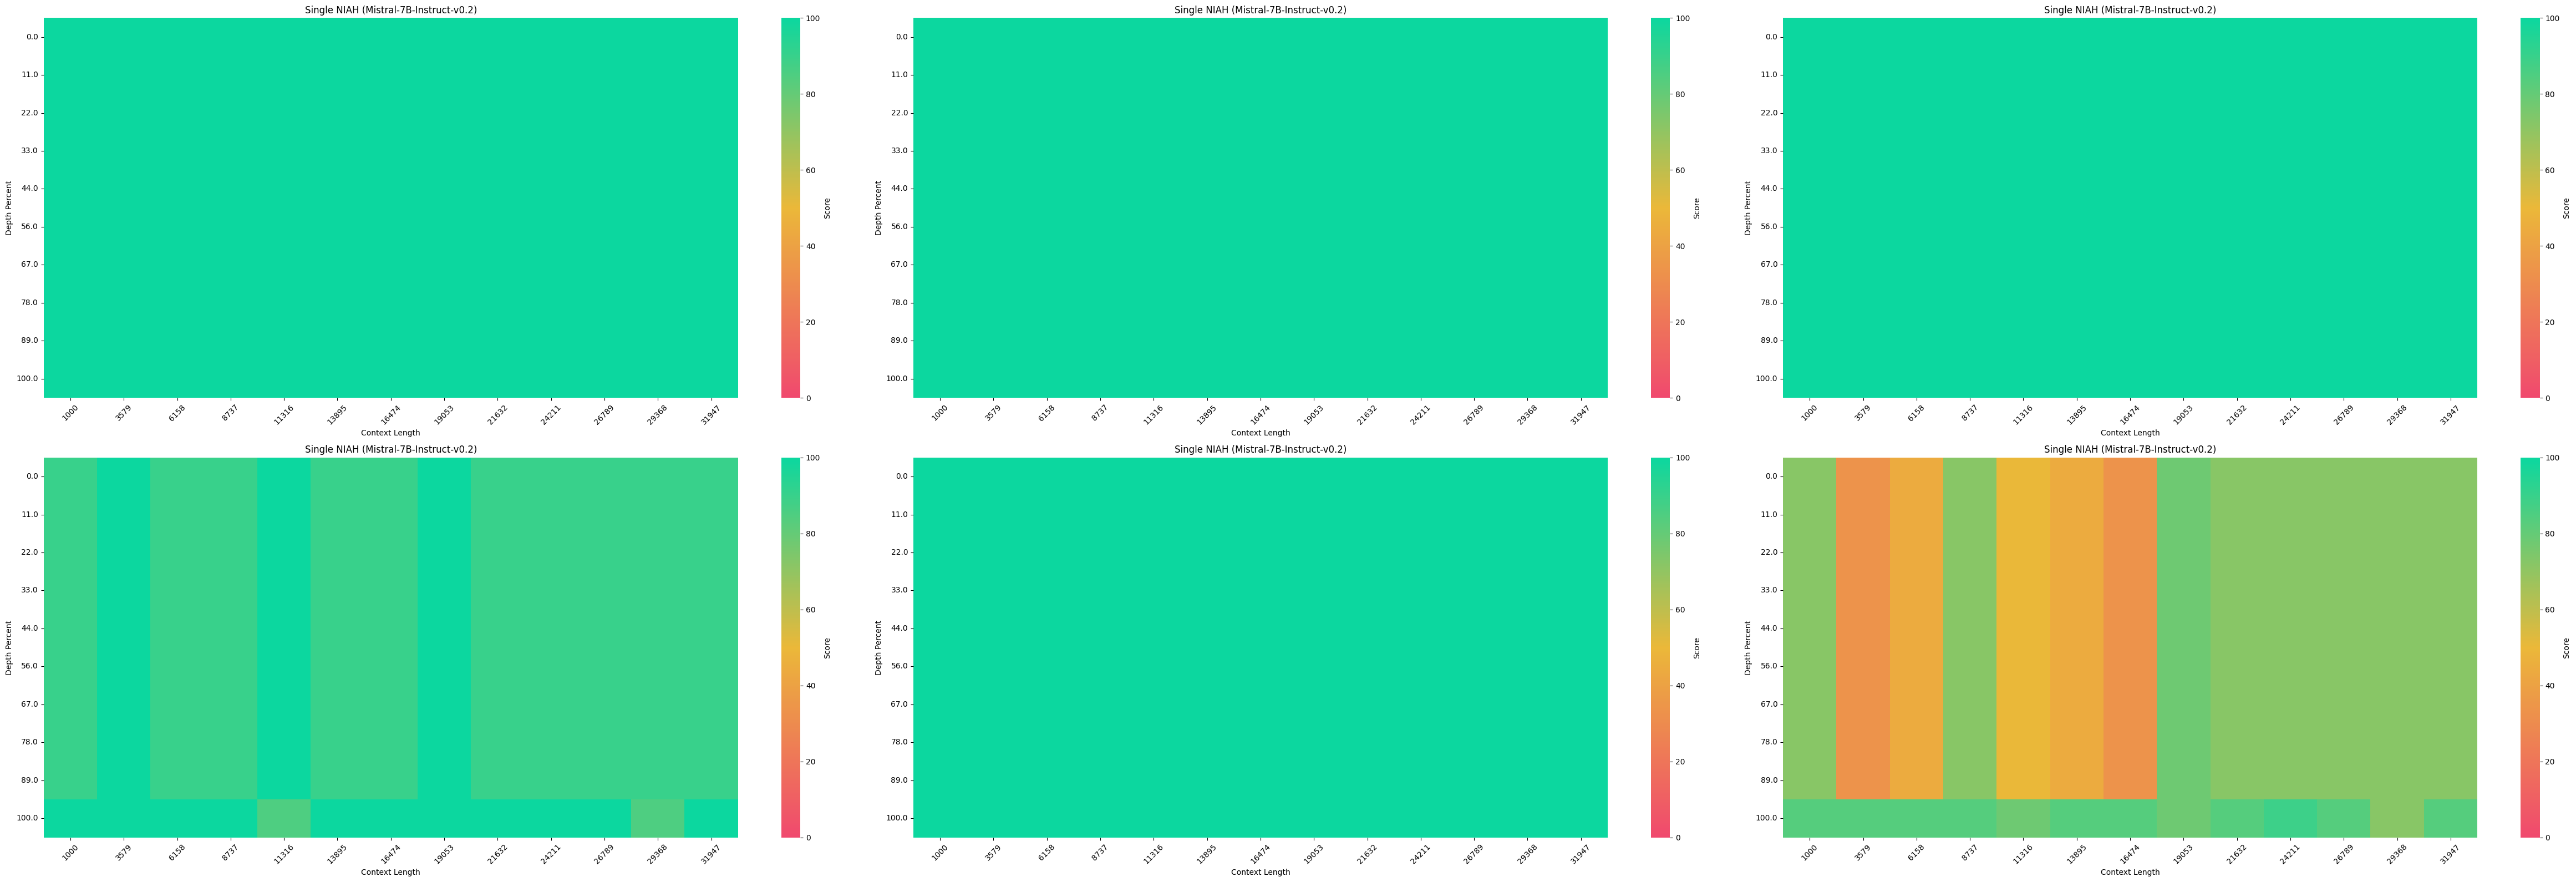

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import json
import os
import glob

# Path to the directory containing JSON results
model_name = 'Mistral-7B-Instruct-v0.2'
# model_name = 'FILM-7B'
# model_name = 'llama-2-7b-80k'
# model_name = 'FILM-7B_musican_girl'
# model_name = 'Llama-2-7b-chat_musican_girl'
model_name = 'Mistral-7B-Instruct-v0.2'
folder_paths = [f'/vepfs/wcf/G/zecheng/Retrieval_Head/results/graph/{model_name}_case{i}' for i in range(6)] 
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(48, 8 * num_rows))
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])


for i, folder_path in enumerate(folder_paths):
    json_files = glob.glob(f"{folder_path}/*.json")
    data = []
    json_files = sorted(json_files, key=lambda x: int(x.split('/')[-1].split('_')[-4]))
    for file in json_files:
        with open(file, 'r') as f:
            json_data = json.load(f)
            # Extracting the required fields
            document_depth = json_data.get("depth_percent", None)
            context_length = json_data.get("context_length", None)
            score = json_data.get("score", None)
            # Appending to the list
            if context_length > 32000: break
            data.append({
                "Document Depth": document_depth,
                "Context Length": context_length,
                "Score": score
            })

    df = pd.DataFrame(data)

    print(df.head())
    print(f"You have {len(df)} rows")

    pivot_table = pd.pivot_table(df, values='Score', index=['Document Depth', 'Context Length'], aggfunc='mean').reset_index()
    pivot_table = pivot_table.pivot(index="Document Depth", columns="Context Length", values="Score")

    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    sns.heatmap(pivot_table, fmt="g", cmap=cmap, cbar_kws={'label': 'Score'}, vmin=0, vmax=100, ax=ax)
    ax.set_title(f'Single NIAH ({model_name})')
    ax.set_ylabel('Depth Percent')
    ax.tick_params(axis='x', rotation=45)  # 旋转x轴标签
    ax.tick_params(axis='y', rotation=0)   # 保持y轴标签水平
    ax.set_xlabel('Context Length')

# 调整布局
plt.tight_layout()

# 保存大图
plt.savefig("combined_heatmaps.png")
plt.show()

In [9]:
json_files

['/vepfs/wcf/G/zecheng/Retrieval_Head/results/graph/Mistral-7B-Instruct-v0.2_case5/Mistral-7B-Instruct-v0_2_len_11316_depth_0_results.json',
 '/vepfs/wcf/G/zecheng/Retrieval_Head/results/graph/Mistral-7B-Instruct-v0.2_case5/Mistral-7B-Instruct-v0_2_len_44842_depth_0_results.json',
 '/vepfs/wcf/G/zecheng/Retrieval_Head/results/graph/Mistral-7B-Instruct-v0.2_case5/Mistral-7B-Instruct-v0_2_len_3579_depth_0_results.json',
 '/vepfs/wcf/G/zecheng/Retrieval_Head/results/graph/Mistral-7B-Instruct-v0.2_case5/Mistral-7B-Instruct-v0_2_len_24211_depth_0_results.json',
 '/vepfs/wcf/G/zecheng/Retrieval_Head/results/graph/Mistral-7B-Instruct-v0.2_case5/Mistral-7B-Instruct-v0_2_len_39684_depth_0_results.json',
 '/vepfs/wcf/G/zecheng/Retrieval_Head/results/graph/Mistral-7B-Instruct-v0.2_case5/Mistral-7B-Instruct-v0_2_len_13895_depth_0_results.json',
 '/vepfs/wcf/G/zecheng/Retrieval_Head/results/graph/Mistral-7B-Instruct-v0.2_case5/Mistral-7B-Instruct-v0_2_len_21632_depth_0_results.json',
 '/vepfs/wcf/G

## Pivot Data

In [1]:
# Path to the directory containing JSON results
model_name = 'llama-2-7b-80k_block_top30'

folder_path = f'/vepfs/wcf/G/zecheng/Retrieval_Head/results/graph/llama-2-7b-80k_musican_girl_case5/'  # Replace with your folder path

# Using glob to find all json files in the directory
json_files = glob.glob(f"{folder_path}/*.json")

# List to hold the data
data = []

# Iterating through each file and extract the 3 columns we need
for file in json_files:
    with open(file, 'r') as f:
        json_data = json.load(f)
        # Extracting the required fields
        document_depth = json_data.get("depth_percent", None)
        context_length = json_data.get("context_length", None)
        score = json_data.get("score", None)
        # Appending to the list
        data.append({
            "Document Depth": document_depth,
            "Context Length": context_length,
            "Score": score
        })

# Creating a DataFrame
df = pd.DataFrame(data)

print (df.head())
print (f"You have {len(df)} rows")

pivot_table = pd.pivot_table(df, values='Score', index=['Document Depth', 'Context Length'], aggfunc='mean').reset_index() # This will aggregate
pivot_table = pivot_table.pivot(index="Document Depth", columns="Context Length", values="Score") # This will turn into a proper pivot
print(pivot_table.iloc[:5, :5])


# Create a custom colormap. Go to https://coolors.co/ and pick cool colors
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])

# Create the heatmap with better aesthetics
plt.figure(figsize=(17.5, 8))  # Can adjust these dimensions as needed
sns.heatmap(
    pivot_table,
    # annot=True,
    fmt="g",
    cmap=cmap,
    cbar_kws={'label': 'Score'},
    vmin=0, vmax=100)

# More aesthetics
plt.title('Fact Retrieval Across Context Lengths ("Needle In A HayStack")')  # Adds a title
plt.xlabel('Token Limit')  # X-axis label
plt.ylabel('Depth Percent')  # Y-axis label
plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
plt.tight_layout()  # Fits everything neatly into the figure area

# Show the plot
plt.show()

NameError: name 'glob' is not defined